In [21]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [22]:
!pip install ultralytics


In [23]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [24]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [25]:
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

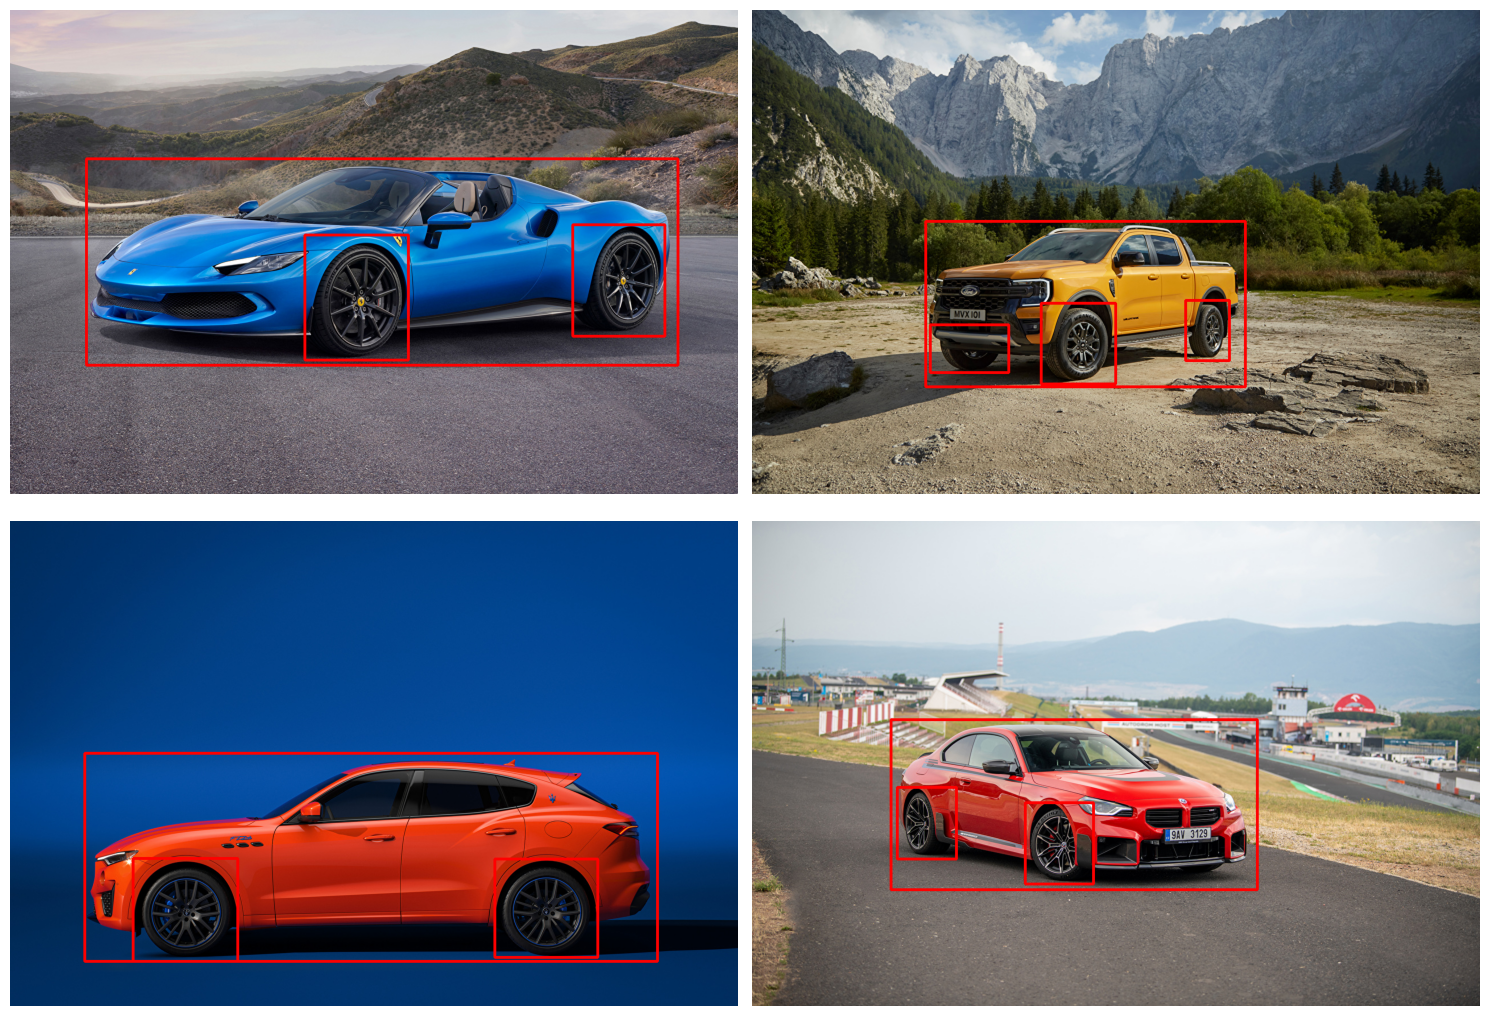

In [26]:
plot(
    image_paths='datasets/datasets/train/images/',
    label_paths='datasets/datasets/train/labels/',
    num_samples=4,
)

In [31]:
%%writefile cars_v8.yaml
path: 'datasets/'
train: 'train/images'
val: 'val/images'

# class names
names:
  0: 'car'
  1: 'wheel'

Overwriting cars_v8.yaml


In [32]:
EPOCHS = 10
!yolo task=detect mode=train model=yolov8s.pt imgsz=1280 data=cars_v8.yaml epochs={EPOCHS} batch=8 name=yolov8s_v8_50e save=True

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=cars_v8.yaml, epochs=10, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_v8_50e5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscrip

In [33]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8s_v8_50e5/weights/best.pt \
source=datasets/datasets/val/images\
imgsz=1280 \
conf = 0.1 \
name=yolov8s_v8_50e_infer1280new2 \
hide_labels=False

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs

image 1/5 /content/datasets/datasets/val/images/McLaren_Novitec_McLaren_765LT_Spider_2022_--_Grey_614485_1280x853.jpg: 864x1280 3 cars, 2 wheels, 112.5ms
image 2/5 /content/datasets/datasets/val/images/Opel_Corsa-e_40_Jahre_(F)_2022_Red_Metallic_613262_1280x853.jpg: 864x1280 4 cars, 4 wheels, 34.3ms
image 3/5 /content/datasets/datasets/val/images/Porsche_718_Spyder_RS_(Worldwide)_(982)_2023_616312_1280x854.jpg: 864x1280 1 car, 1 wheel, 34.3ms
image 4/5 /content/datasets/datasets/val/images/Toyota_Crown_Platinum_(North_America)_2022_Red_613394_1280x853.jpg: 864x1280 5 cars, 2 wheels, 34.3ms
image 5/5 /content/datasets/datasets/val/images/Toyota_GR_Supra_GT4_EVO_(A90)_2023_Red_Metallic_613543_1

In [34]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

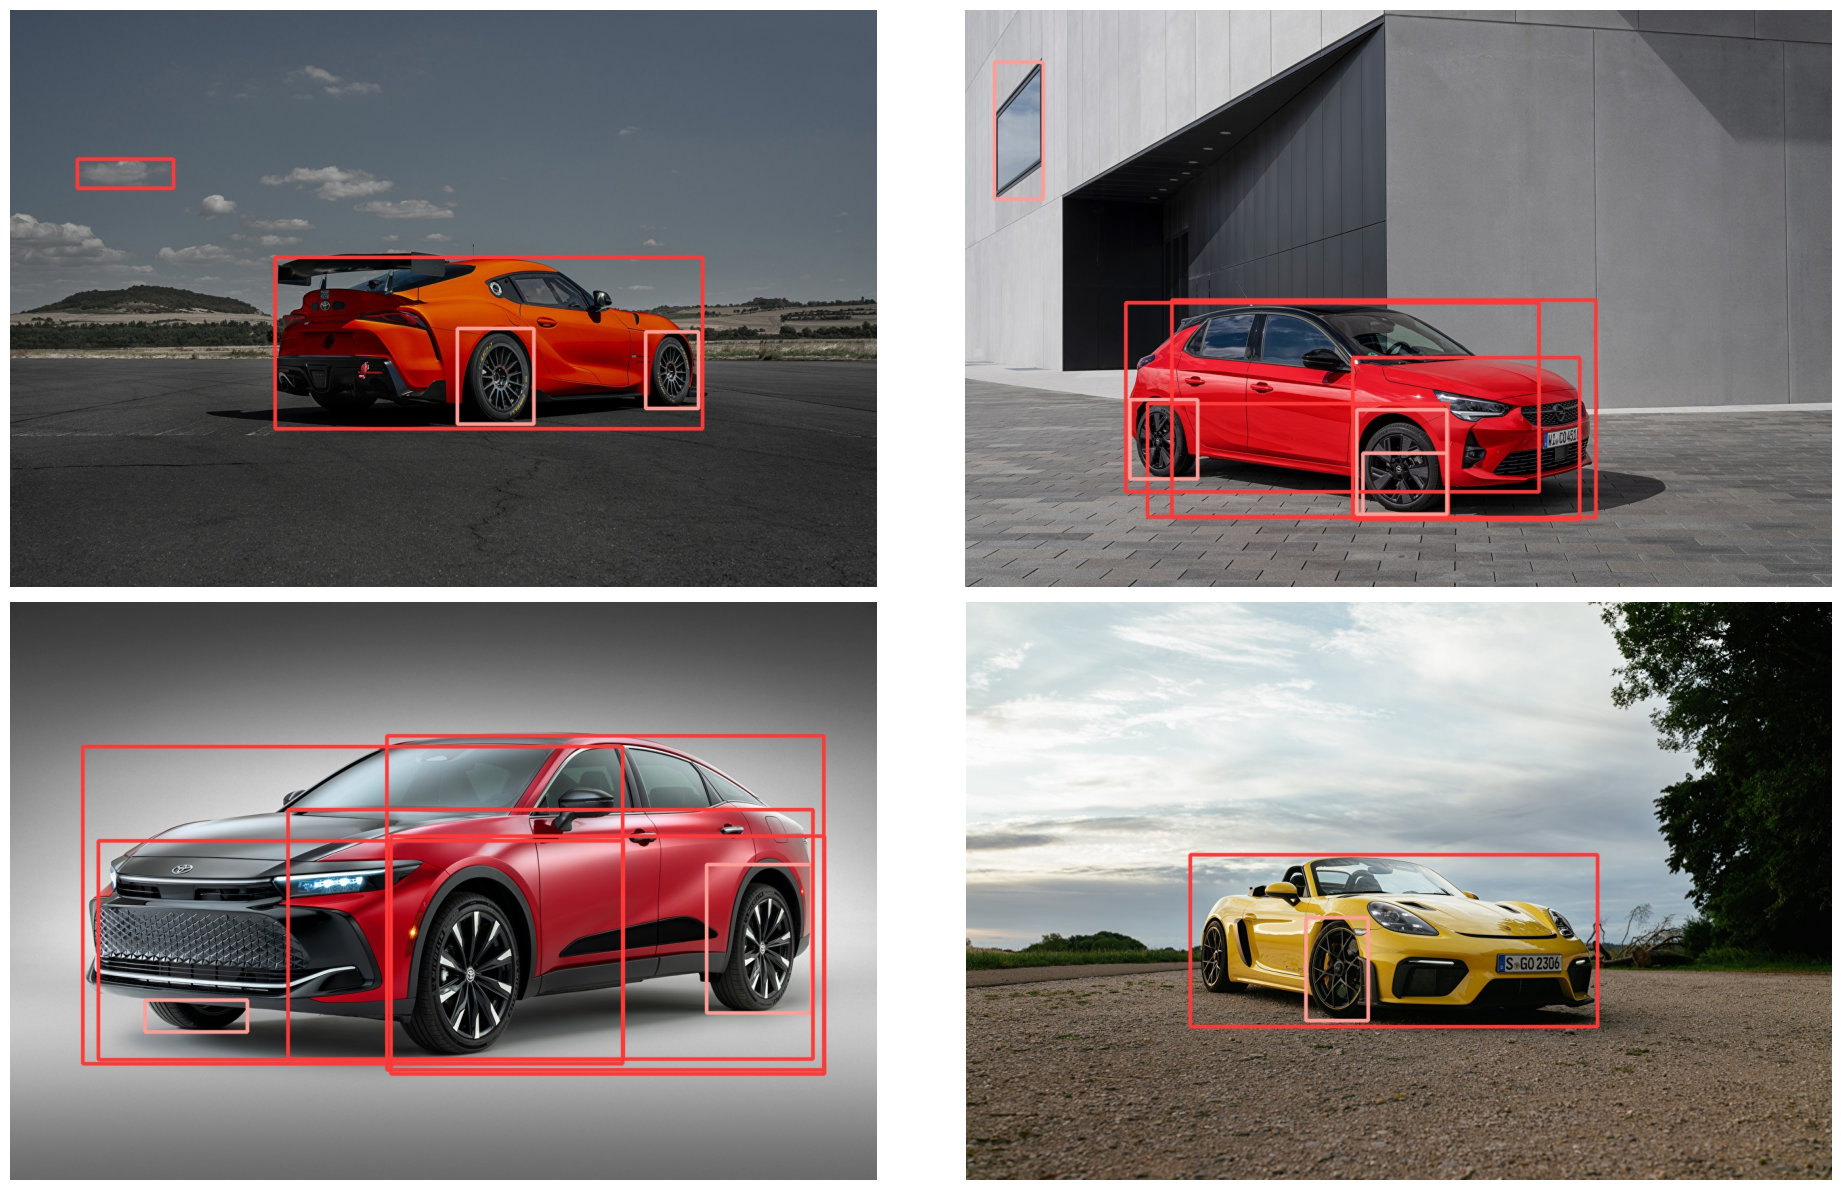

In [37]:
visualize('runs/detect/yolov8s_v8_50e_infer1280new2')